# GRAD-E1426 Network Analysis: Assignment 2 
#### Janine De Vera, 219848

## Characterizing the Scope and Depth of Trade Agreements

Over the last half century, the world has seen historic changes in the international trade landscape, marked by increasing fragmentation of production processes through global value chains and deepening of trade relations through the proliferation of **preferential trade agreements (PTAs)**. Based on the World Trade Organization's database, the number of trade agreements in force grew six-fold from 50 in 1990 to 306 in 2020. 

With the sharp rise in trade agreements came a new interest in their depth and scope. Before the mid 1990s, PTAs mostly invovled provisions for market access and preferential tariffs. The last 30 years have seen a spread of contemporary forms of cooperation, specifically *deeper* agreements which involve provisions such as regulatory issues, intellectual property, human rights, political dialogue and investment. 

This network analysis aims to characterize how trade agreements have developed over the last 50 years -- how deep have they become, who are the key players or regions involved. 

In [2]:
import graph_tool.all as gt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import math


In [3]:
os.getcwd()

'/Users/janinedevera/Documents/School/MDS 2021-2023/Semester 4/2 Network Analysis/Assignments/network-analysis-trade-agreements/code'

## I. Data

For this analysis, I use World Bank's *Horizontal Trade Agreements Database*. This dataset contains preferential trade agreements (PTAs) notified to the World Trade Organization as of 2015, year of enforcement, type, and variables indicating the presence (or absence) of PTA provisions. All information is recorded bilaterally, as seen below. 

The _**depth**_ variable, pertaining to the depth or scope of a trade agreement, is calculated by summing the number of key PTA provisions that appear in a particular agreement. The maximum possible value is 52.

There are two main types of provisions - _**wto_plus**_ and _**wto_x**_. The former includes PTA provisions under the mandate of the WTO. This includes anti-dumping policies, customs duties and export taxes. The latter, _**wto_x**_ (WTO extra), pertains to provisions outside the mandate of the WTO such as consumer protection, environmental laws and immigration policies.

In [190]:
pta = pd.read_excel("../data/WB_Bilateral PTAs_2018.xlsx")

In [191]:
pta['depth'] = pta.filter(regex=r'^wto(?!.*_le$)').sum(axis=1)
pta['depth_le'] = pta.filter(regex=r'^wto.*_le$').sum(axis=1)
pta.head()

cty1 iso1     cty2 iso2  year agreement  entry_force type   
0  Angola  AGO  Burundi  BDI  1994    COMESA         1994   CU  \
1  Angola  AGO  Burundi  BDI  1995    COMESA         1994   CU   
2  Angola  AGO  Burundi  BDI  1996    COMESA         1994   CU   
3  Angola  AGO  Burundi  BDI  1997    COMESA         1994   CU   
4  Angola  AGO  Burundi  BDI  1998    COMESA         1994   CU   

   wto_plus_ftaindustrial  wto_plus_ftaagriculture  ...   
0                       1                        1  ...  \
1                       1                        1  ...   
2                       1                        1  ...   
3                       1                        1  ...   
4                       1                        1  ...   

   wto_X_regionalcooperation_le  wto_X_researchandtechnology_le  wto_X_sme_le   
0                             0                               0             0  \
1                             0                               0             0   
2                             0                               0             0   
3                             0                               0             0   
4                             0                               0             0   

   wto_X_socialmatters_le  wto_X_statistics_le  wto_X_taxation_le   
0                       0                    0                  0  \
1                       0                    0                  0   
2                       0                    0                  0   
3                       0                    0                  0   
4                       0                    0                  0   

   wto_X_terrorism_le  wto_X_visaandasylum_le  depth  depth_le  
0                   0                       0     29        22  
1                   0                       0     29        22  
2                   0                       0     29        22  
3                   0                       0     29        22  
4                   0                       0     29        22  

[5 rows x 114 columns]

In [259]:
# normalize depth scores
pta['depth_norm'] = (pta['depth'] - pta['depth'].min()) / (pta['depth'].max() - pta['depth'].min()) * (5 - 0.3) + 0.3

# indicator variable for wto_x
pta['wto_x'] = 0
for column in pta.columns:
    if column.startswith("wto_X_"):
        pta['wto_x'] = pta['wto_x'] | (pta[column] > 0)
pta['wto_x'] = pta['wto_x'].astype(int)

# indicator variable for wto_x_le
pta['wto_x_le'] = 0
for column in pta.columns:
    if "wto_X" in column and "_le" in column:
        pta['wto_x_le'] = pta['wto_x_le'] | (pta[column] > 1)
pta['wto_x_le'] = pta['wto_x_le'].astype(int)

# indicator variable for wto_x_core
pta['wto_x_core'] = 0
for column in pta.columns:
    if column in ['wto_X_competitionpolicy_le', 'wto_X_ipr_le', 'wto_X_investment_le', 'wto_X_movementofcapital_le']:
        pta['wto_x_core'] = pta['wto_x_core'] | (pta[column] > 0)
pta['wto_x_core'] = pta['wto_x_core'].astype(int)

I also supplement this dataset with other country-level information such as broad geographic region, economy size (GVA), and income classification.

*Region*

In [7]:
regions = pd.read_excel("../data/WB_regions.xls", skiprows=4, index_col=0)

In [8]:
regions = regions[['Economy', 'Code', 'Region_Clean', 'Income group']].dropna(subset = ['Region_Clean'])
regions.head()

Economy Code                Region_Clean         Income group
x                                                                      
1     Afghanistan  AFG                  South Asia           Low income
2         Albania  ALB                      Europe  Upper middle income
3         Algeria  DZA  Middle East & North Africa  Lower middle income
4  American Samoa  ASM         East Asia & Pacific  Upper middle income
5         Andorra  AND                      Europe          High income

*Economy size*

In [9]:
economy = pd.read_excel("../data/WB_economy.xlsx", skiprows = 4)
economy = economy.iloc[:, [1, 62]].rename(columns={economy.columns[62]: 'gva'})

In [10]:
economy['gva'].apply(lambda x: round(((x - economy['gva'].min()) / (economy['gva'].max() - economy['gva'].min())) * 100 + 10) if pd.notnull(x) else np.nan)

0      10.0
1       NaN
2      10.0
3       NaN
4      10.0
       ... 
261    10.0
262    10.0
263    10.0
264    10.0
265    10.0
Name: gva, Length: 266, dtype: float64

The merged dataset _**trade_df**_ is constructed such that each observation is unique for a country-pair and agreement.

In [195]:
# merge datasets
trade_df = pd.merge(pta, regions, left_on='iso1', right_on='Code')
trade_df = pd.merge(trade_df, economy, left_on='iso1', right_on='Country Code')

In [198]:
# remove duplicate pairs
trade_df['sorted_iso'] = trade_df[['iso1', 'iso2']].apply(lambda x: tuple(sorted(x)), axis=1)
trade_df = trade_df.drop_duplicates(subset=['sorted_iso', 'agreement'], keep='first')


## II. Plots

Next, I structure and prepare the data in a way that is compatible with the **Graph()** class of graph tool. Among other things, I create a list of unique countries which will serve as nodes and country-pair agreements which will serve as edges. I also add name properties for nodes and edges are added for ease of reference.

In [200]:
# unique nodes and edge country pair agreements
nodes = trade_df['iso1'].drop_duplicates()
pairs = trade_df[['iso1', 'iso2', 'agreement']].drop_duplicates(keep='first')

# edge pairs as list of tuples 
pairs = list(zip(pairs.iso1, pairs.iso2))

I then create the Graph object and define the nodes and edges.

In [201]:
# instantiate undirected Graph object
trade_graph = gt.Graph(directed=False)

In [202]:
# add nodes and edges from pairs list, create country_name and pair_name as properties
country_name = trade_graph.new_vertex_property('string')
pair_name = trade_graph.new_edge_property('object')

node_list = {}
for pair in pairs:
    for name in pair:
        if name not in node_list:
            v = trade_graph.add_vertex()
            node_list[name] = v
            country_name[v] = name
    e = trade_graph.add_edge(node_list[pair[0]], node_list[pair[1]])
    pair_name[e] = (pair[0], pair[1]) 

trade_graph.vertex_properties["country_name"] = country_name
trade_graph.edge_properties["pair_name"] = pair_name

In [211]:
pos = gt.sfdp_layout(trade_graph)
#pos = gt.fruchterman_reingold_layout(trade_graph, n_iter=500)

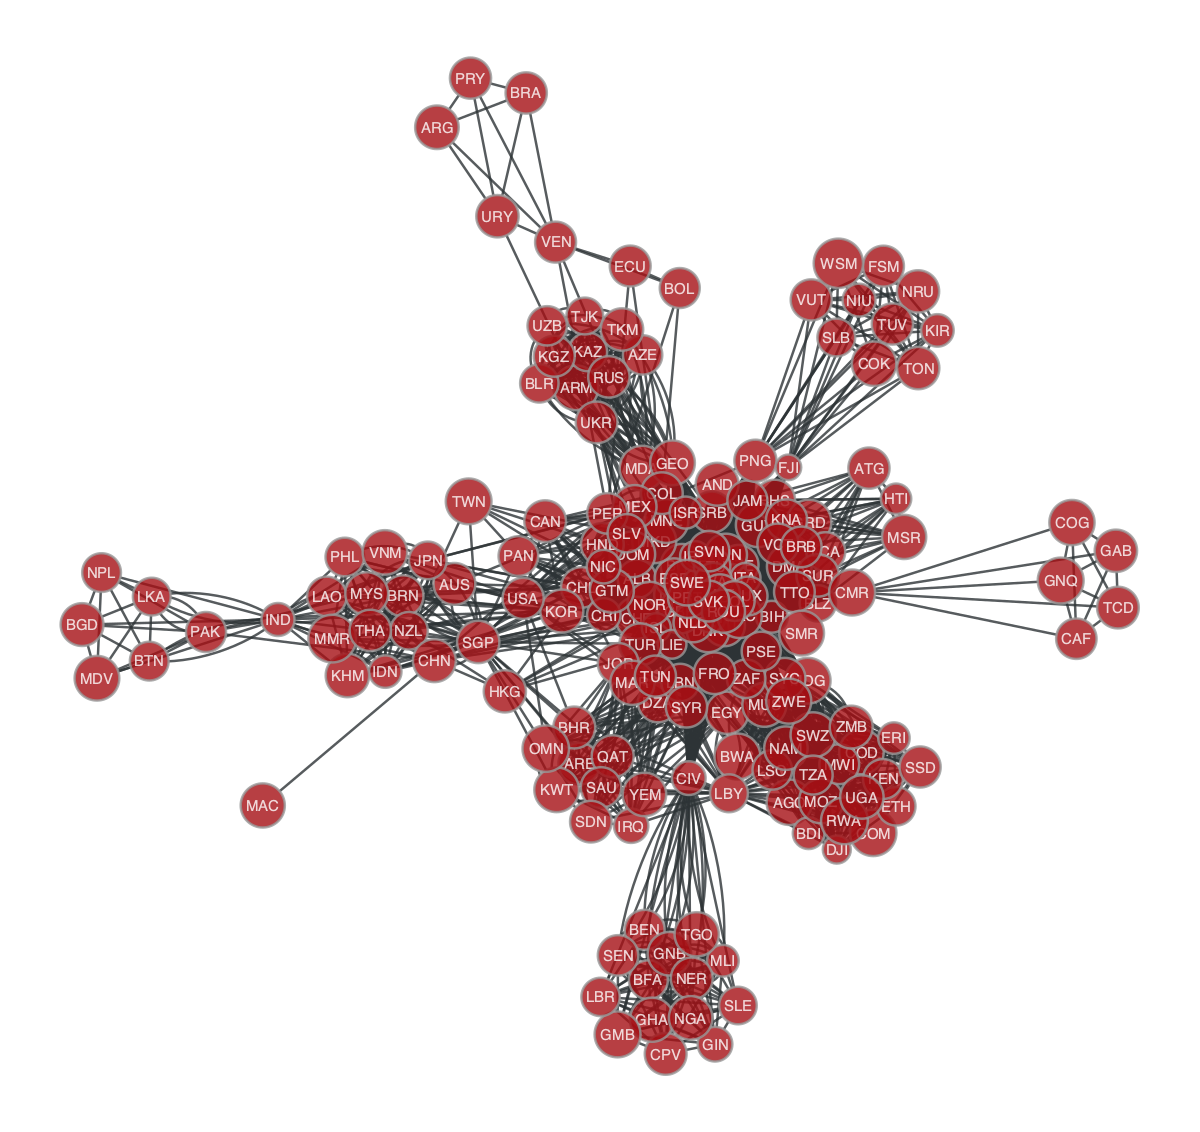

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x168ce8d30, at 0x16d958250>

In [212]:
gt.graph_draw(trade_graph, pos = pos, vertex_text = country_name, vertex_font_family='sans serif')

For better visualization, I also add other country-level and agreement-level information as properties to the graph. Node colors correspond to a country's geographical region, edge weight corresponds to PTA depth, and edge color corresponds to whether an agreement contains provisions not mandated by the WTO (_**wto_x**_).

*Node color: region*

In [213]:
# list of unique country names and corresponding region
country1 = trade_df[['iso1']]
country2 = trade_df[['iso2']].rename(columns={'iso2': 'iso1'})

countries_all = pd.concat([country1, country2], ignore_index = True).drop_duplicates(keep='first')
countries_all = pd.merge(countries_all, regions, left_on='iso1', right_on='Code')[['iso1', 'Region_Clean']]

In [214]:
# region-color dictionary  
region_colors = {'Sub-Saharan Africa':'#FA9265', # orange
                 'Europe': '#7ACCE1', # blue
                 'Middle East & North Africa': '#FA9265', # orange
                 'Latin America & Caribbean': '#90BC62', # green
                 'East Asia & Pacific': '#C7448C', # pink
                 'Central Asia': '#C7448C', # pink
                 'South Asia': '#C7448C', # pink
                 'North America': '#A68FC7'} # purple

# map colors to regions
countries_all['region_colors'] = countries_all['Region_Clean'].map(region_colors)

# country-color dictionary
country_colors = (
    countries_all[['iso1', 'region_colors']]
    .drop_duplicates()
    .set_index('iso1')
    .to_dict()['region_colors']
    )

In [215]:
# add color as node property
node_color = trade_graph.new_vertex_property('string')

for v in trade_graph.vertices():
    name = trade_graph.vp.country_name[v]
    try:
        color_map = country_colors.get(name,None)
    except KeyError:
        trade_graph.remove_vertex(v)
        continue
    node_color[v] = color_map

trade_graph.vertex_properties["node_color"] = node_color

*Edge weight: depth*

In [216]:
# define edge size dictionary
edge_size = (
    trade_df[['sorted_iso', 'depth_norm']]
    .drop_duplicates()
    .set_index('sorted_iso')
    .to_dict()['depth_norm']
    )

In [217]:
# add depth as edge property
edge_weight = trade_graph.new_edge_property('float')

for e in trade_graph.edges():
    name = trade_graph.ep.pair_name[e]
    if name in edge_size:
        edge_weight[e] = edge_size[name]
    else:
        edge_weight[e] = 0.0  # set default weight value to 0.0 if not found in the dictionary

trade_graph.edge_properties['edge_weight'] = edge_weight

*Edge color: WTO-X*

In [218]:
# agreement-color dictionary  
wto_colors = {1:'#FAEABA', # yellow
              0: '#EBEBEB'} # white

# map colors to agreements
trade_df['wto_colors'] = trade_df['wto_x_core'].map(wto_colors)

# pair-color dictionary
pair_colors = (
    trade_df[['sorted_iso', 'wto_colors']]
    .drop_duplicates()
    .set_index('sorted_iso')
    .to_dict()['wto_colors']
    )

In [219]:
# add color as edge property
edge_color = trade_graph.new_edge_property('string')

for e in trade_graph.edges():
    name = trade_graph.ep.pair_name[e]
    if name in pair_colors:
        edge_color[e] = pair_colors[name]
    else:
        edge_color[e] = '#EBEBEB'

trade_graph.edge_properties['edge_color'] = edge_color

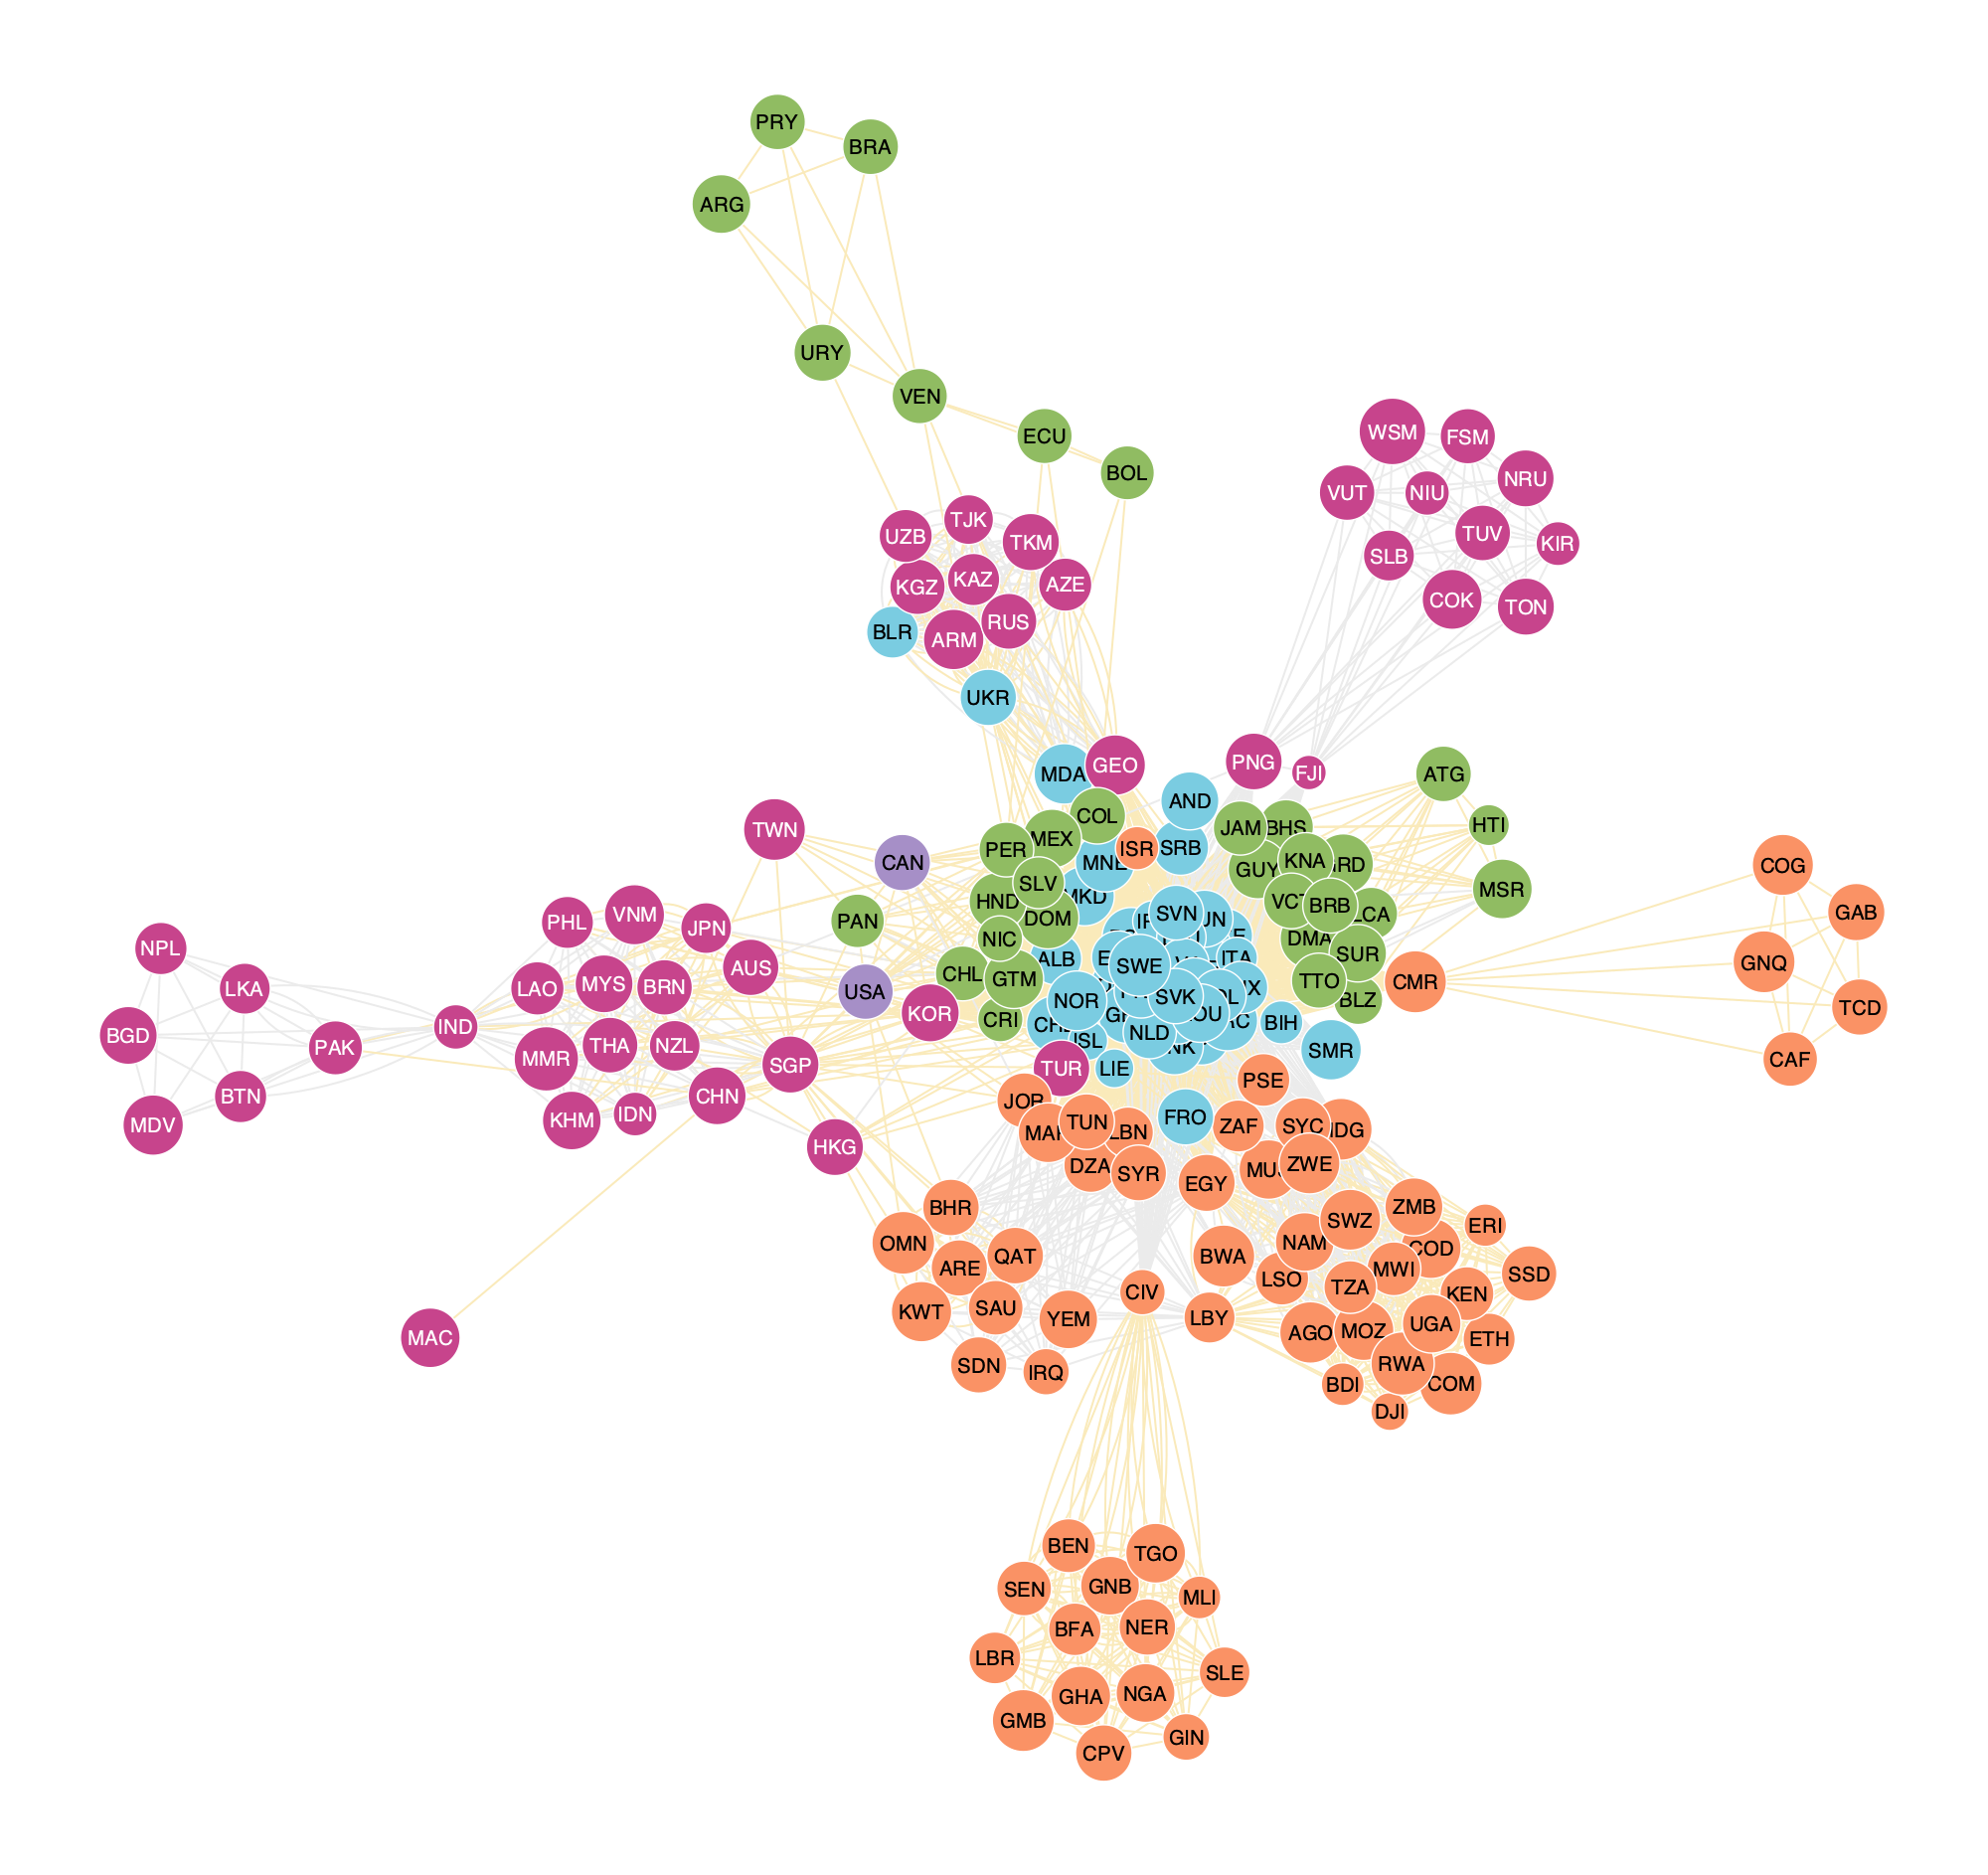

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x168ce8d30, at 0x1677fa1f0>

In [250]:
gt.graph_draw(trade_graph, pos=pos, 
    vertex_fill_color=node_color, 
    vertex_size=17, 
    vertex_color='#FFFFFF',
    vertex_pen_width=0.7,
    vertex_anchor=0,
    vertex_font_family='sans serif',
    vertex_text=country_name,
    edge_color=edge_color,
    #edge_pen_width=edge_weight,
    output_size=(1000,1000))
    #output="../charts/trade_complete.png")

*Node size: economy size*

In [27]:
plt.switch_backend("cairo")

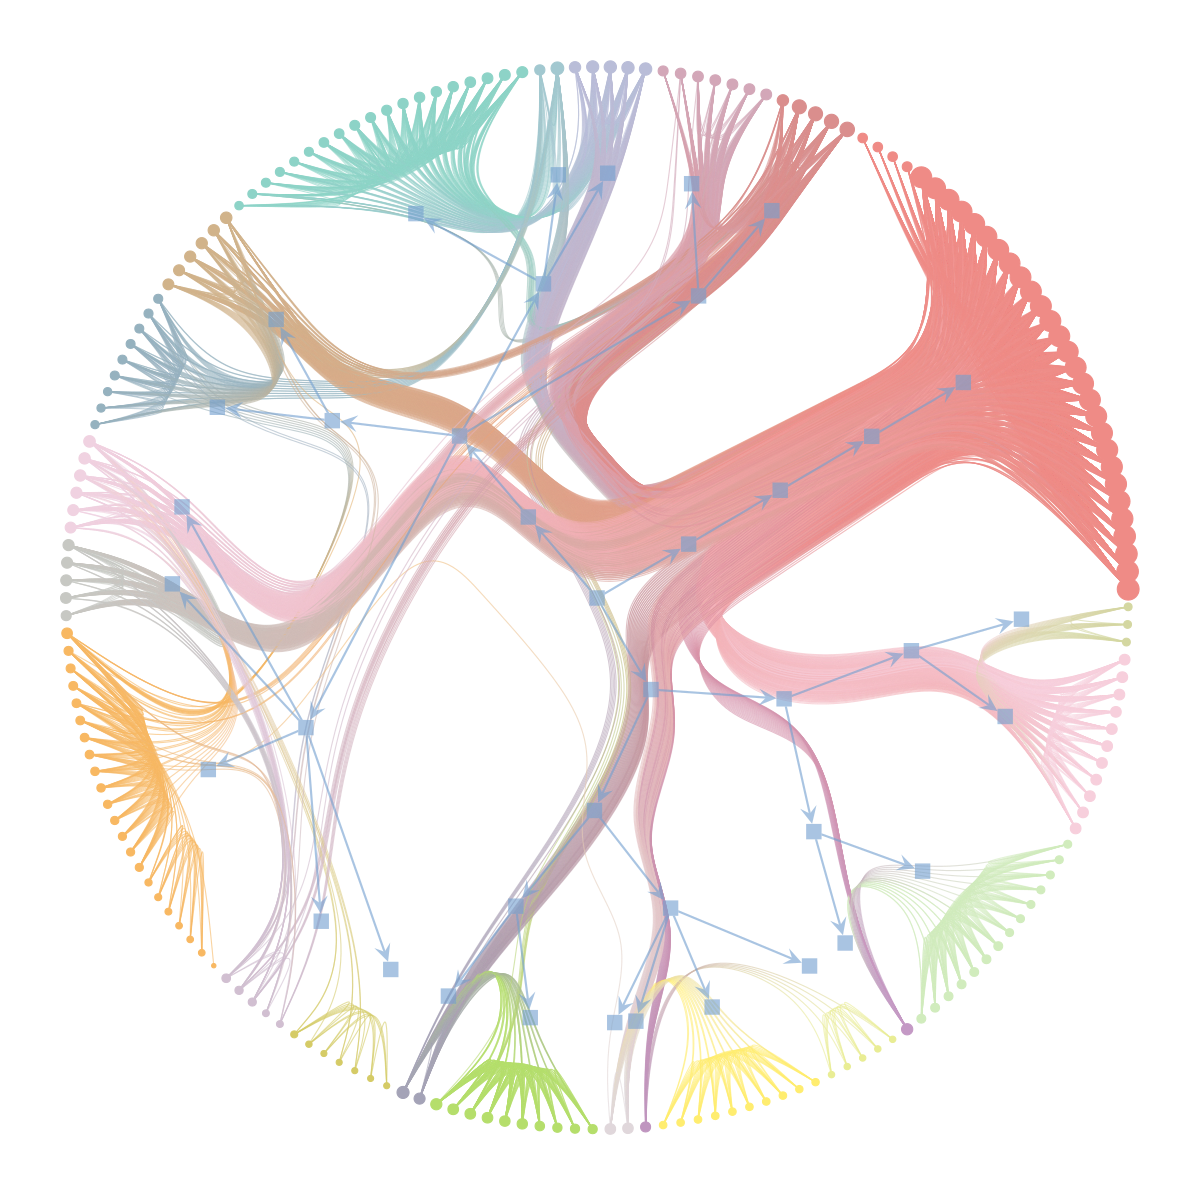

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x28f06bee0, at 0x28ea15550>,
 <GraphView object, directed, with 229 vertices and 228 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x28ea15040, at 0x1678ecb50>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x28ea15040, at 0x1678ec9a0>, False), at 0x28ea15040>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x28ea15040, at 0x1678ec160>)

In [28]:
state = gt.minimize_nested_blockmodel_dl(trade_graph)
state.draw()

## III. Time Comparison

In [256]:
def sub_graph(df, output_size, depth=True):
    # prepare df
    nodes = df['iso1'].drop_duplicates()
    pairs = df[['iso1', 'iso2', 'agreement']].drop_duplicates(keep='first')
    pairs = list(zip(pairs.iso1, pairs.iso2))

    # create graph object
    graph = gt.Graph(directed=False)
    country_name = graph.new_vertex_property('string')
    pair_name = graph.new_edge_property('object')

    node_list = {}
    for pair in pairs:
        for name in pair:
            if name not in node_list:
                v = graph.add_vertex()
                node_list[name] = v
                country_name[v] = name
        e = graph.add_edge(node_list[pair[0]], node_list[pair[1]])
        pair_name[e] = (pair[0], pair[1]) 

    graph.vertex_properties["country_name"] = country_name
    graph.edge_properties["pair_name"] = pair_name

    # add color property
    node_color = graph.new_vertex_property('string')

    for v in graph.vertices():
        name = graph.vp.country_name[v]
        try:
            color_map = country_colors.get(name,None)
        except KeyError:
            graph.remove_vertex(v)
            continue
        node_color[v] = color_map

    graph.vertex_properties["node_color"] = node_color

    # add edge size property
    edge_weight = graph.new_edge_property('float')

    for e in graph.edges():
        name = graph.ep.pair_name[e]
        if name in edge_size:
            edge_weight[e] = edge_size[name]
        else:
            edge_weight[e] = 0.0  # set default weight value to 0.0 if not found in the dictionary

    graph.edge_properties['edge_weight'] = edge_weight

    # add edge color property
    edge_color = graph.new_edge_property('string')

    for e in graph.edges():
        name = graph.ep.pair_name[e]
        if name in pair_colors:
            edge_color[e] = pair_colors[name]
        else:
            edge_color[e] = '#EBEBEB'

    graph.edge_properties['edge_color'] = edge_color

    if depth:
        gt.graph_draw(graph, pos=pos, 
            vertex_fill_color=node_color, 
            vertex_size=18, 
            vertex_text=country_name, 
            vertex_font_family='sans serif',
            vertex_anchor=0,
            vertex_color='#FFFFFF',
            vertex_pen_width=0.7,
            edge_pen_width=edge_weight,
            edge_color=edge_color,
            output_size=output_size)
    else:
        gt.graph_draw(graph, pos=pos, 
            vertex_fill_color=node_color, 
            vertex_size=18, 
            vertex_text=country_name, 
            vertex_font_family='sans serif',
            vertex_anchor=0,
            vertex_color='#FFFFFF',
            vertex_pen_width=0.7,
            edge_pen_width=0.8,
            edge_color=edge_color,
            output_size=output_size)

### Trade agreements before 2000

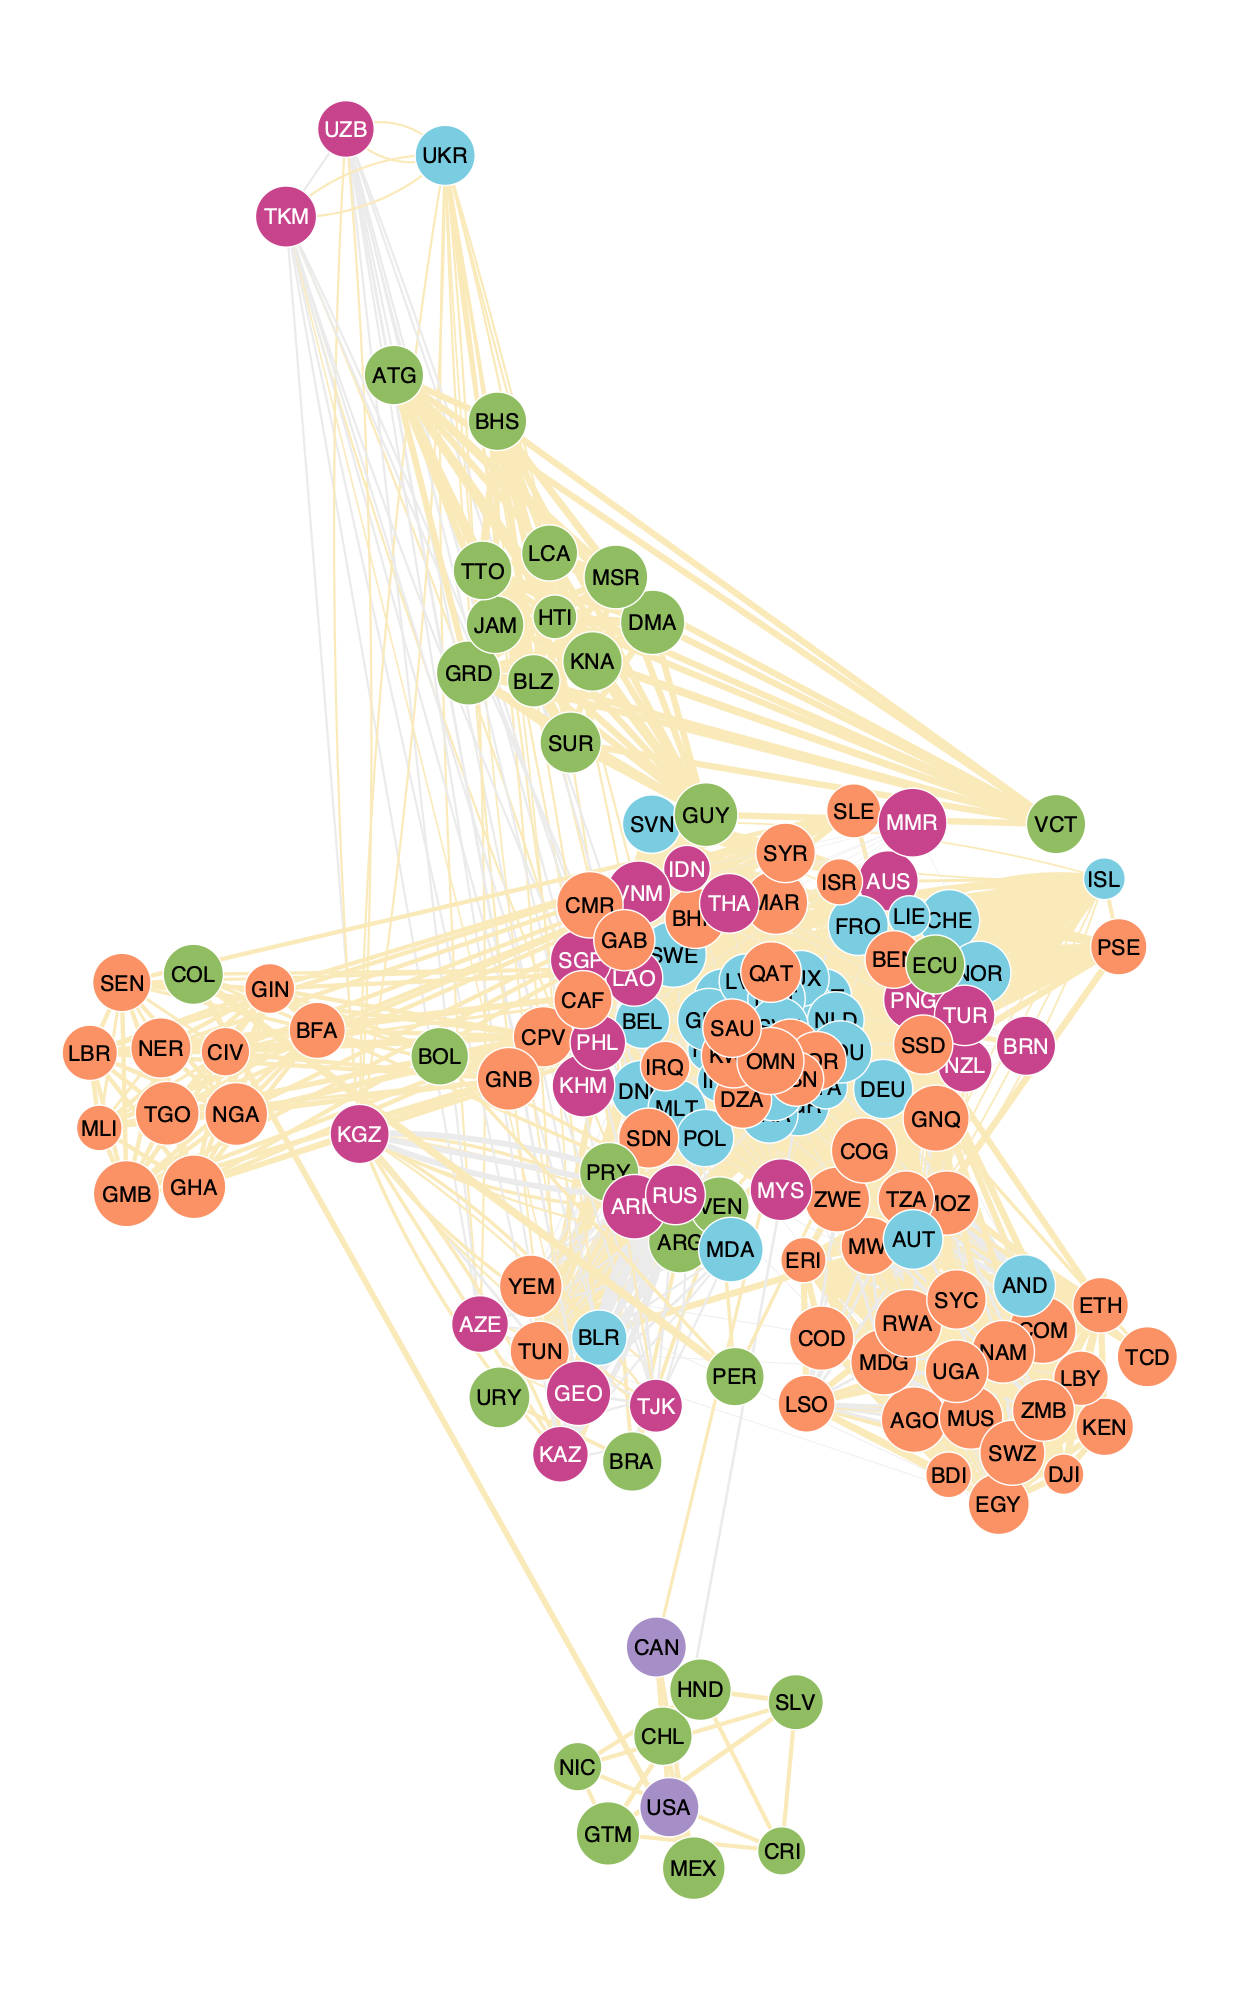

In [258]:
df_time1 = trade_df[trade_df['entry_force'] < 2000]
sub_graph(df_time1, (1000,1000), depth=True)

### Trade agreements after 2000

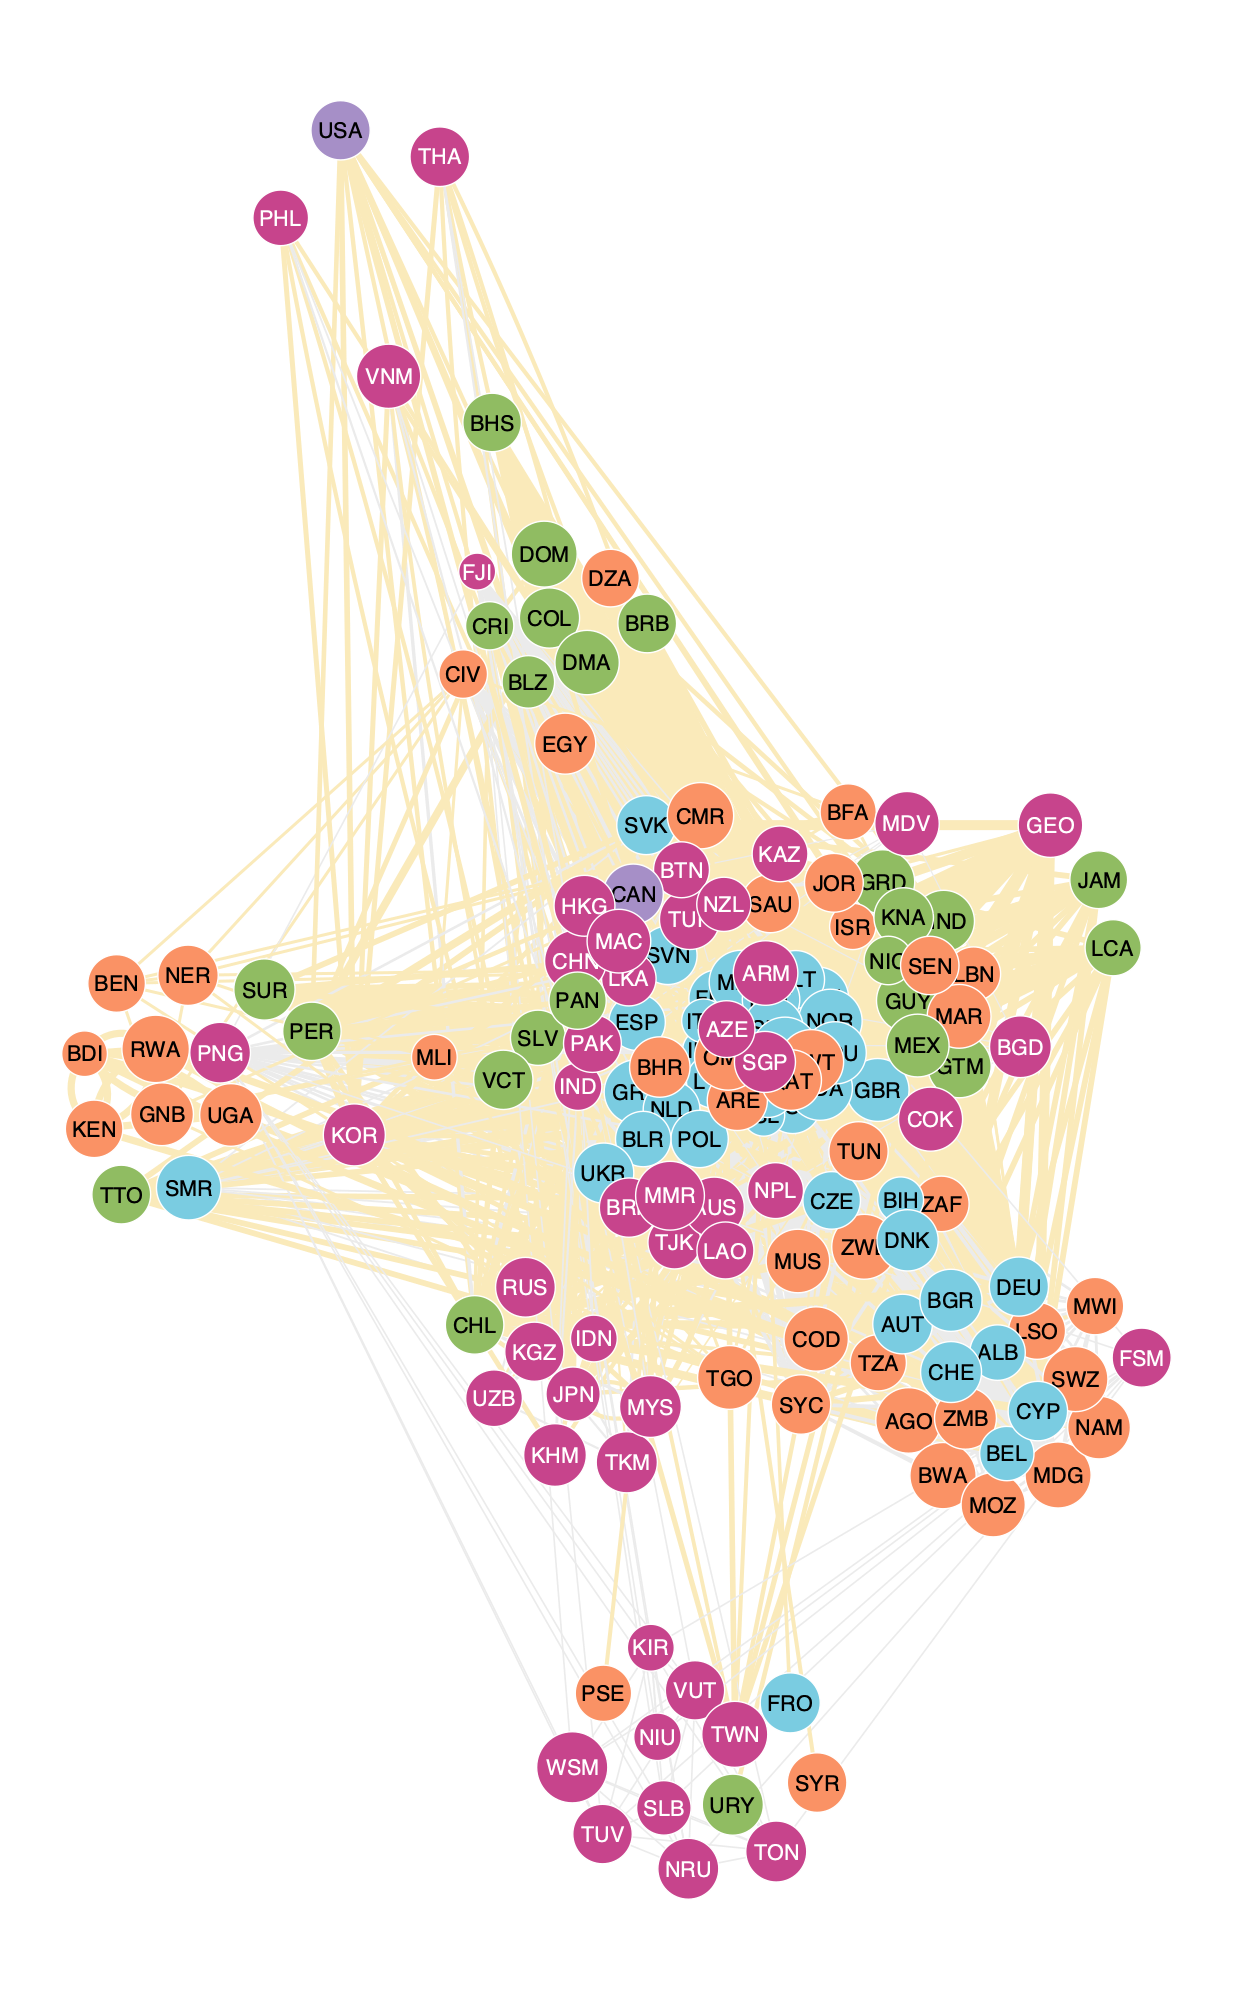

In [247]:
df_time2 = trade_df[trade_df['entry_force'] >= 2000]
sub_graph(df_time2, (1000,1000), depth=True)